In [1]:
from functions_sup import *

## Machine Predictive Maintenance Classification
 Artificial Dataset to predict machine failure (binary) and type (multiclass)

In [2]:
# import data
pm = pd.read_csv('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/predictive_maintenance.csv',sep=',')

The dataset consists of 10 000 data points stored as rows with 9 variables in columns:
- UID unique identifier
- Type: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- Air temperature [Kelvin]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.
- Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- Rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- Torque [Newton meter]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. 
- Target :'machine failure' label that indicates, whether the machine has failed in this particular data point.
- Types: independent types of failure; The machine failure consists of five independent failure modes: 
    - Tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 and 240 mins.
    - Heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the rotational speed is below 1380 rpm.
    - Power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.
    - Overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.
    - Random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. Less than could be expected for 10,000 datapoints in our dataset.


In [3]:
pm.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
dtype: int64

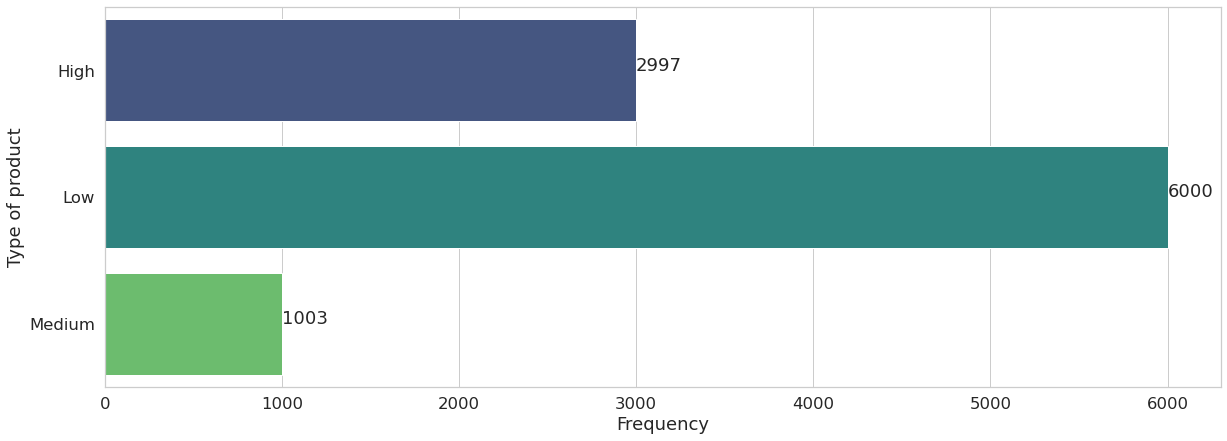

In [4]:
plt.figure(figsize=(20,7))
sns.set_theme(font_scale=1.5,style="whitegrid")
pl = sns.countplot(y=pm["Type"],palette="viridis")
plt.yticks([0,1,2], labels=['High','Low','Medium'])
pl.set(xlabel="Frequency")
pl.set(ylabel="Type of product")
for p in pl.patches:
        percentage = p.get_width()
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        pl.annotate(percentage, (x, y))
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/qualityproductPM.png')


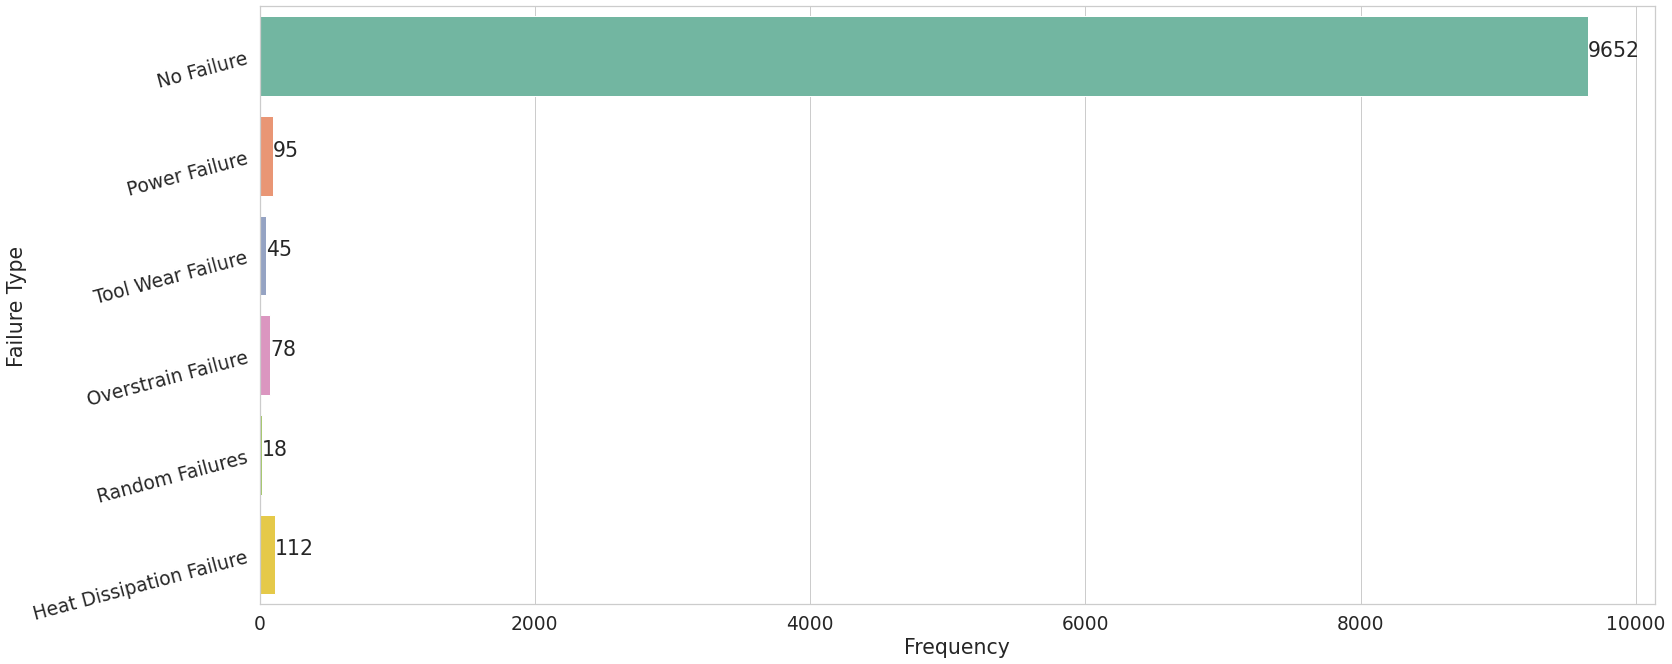

In [20]:
plt.figure(figsize=(25,11))
sns.set_theme(font_scale=1.7,style="whitegrid")
pl = sns.countplot(y=pm["Failure Type"],palette="Set2")
pl.set(xlabel="Frequency")
for p in pl.patches:
        percentage = p.get_width()
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        pl.annotate(percentage, (x, y))
plt.yticks(rotation=15)
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/unbalancedPM.png')

### Data Strategy
- Delete random failures, they are unpredictable, change the Machine Status to 0 and Failure Type to No Failure.
- Code the labels associated to variables Type and Failure Type.
- Create Heat dissipation variable: absolute value of the difference between Air temperature and Process temperature in Kelvin in absolute value.
- Create Power [Watt x sec] variable: product between Torque and rotational speed expressed in rad/s.
- Create Overstrain [min x Nm] variable: product between Tool wear and torque which express the friction per minute of exposure.
(These 3 variables are created based on the definition of the Failure Type)
- Drop useless variables: Unique idenifier, product ID, Air temperature, Torque.  
- Re-order the variable, Machine status and Targets are the last two.

In [6]:
pm=pre_process_PM(pm)

/home/nico_ronzo/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


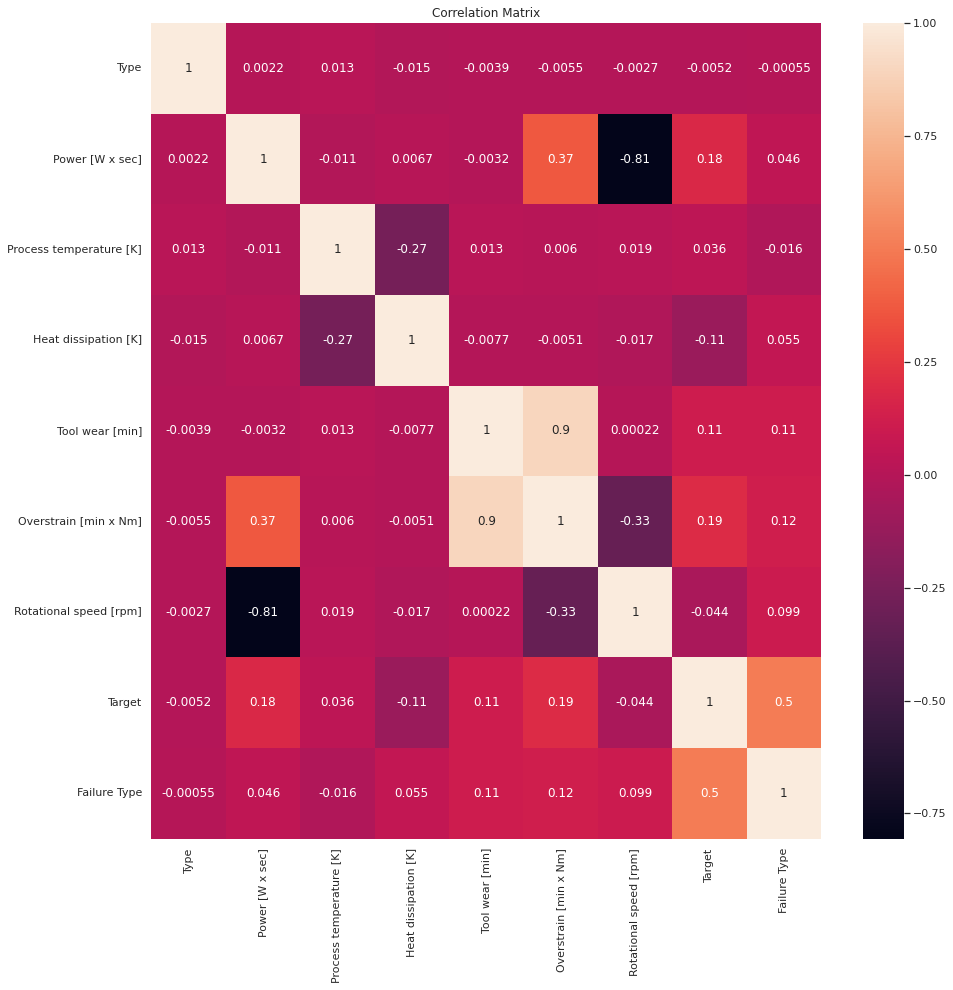

In [6]:
plt.figure(figsize=(15,15))
pl = sns.heatmap(pm.corr(), annot=True)
pl.set_title("Correlation Matrix")
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/correlationPM.png') 

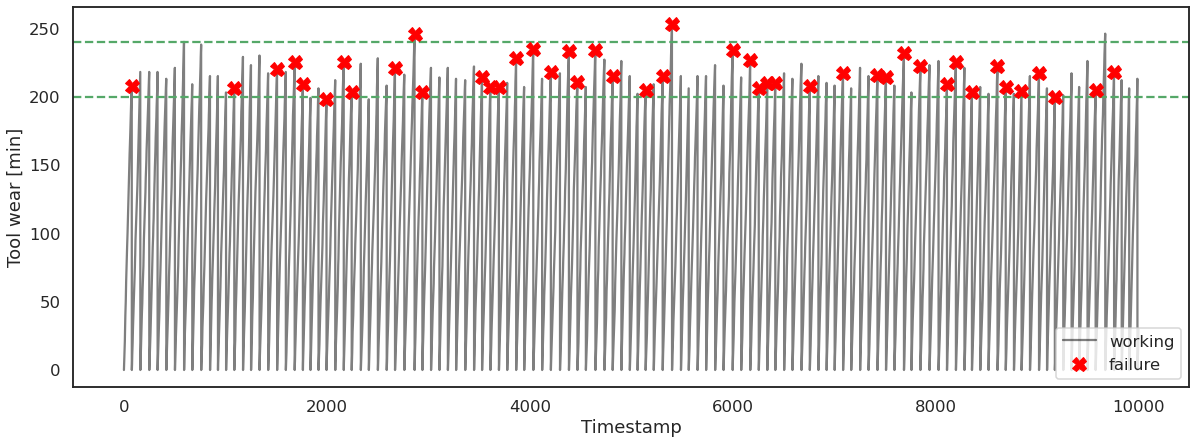

In [7]:
TF=pm[pm['Failure Type']==4]
sns.set_theme(style="white")
sns.set_context('talk')
_ = plt.figure(figsize=(20,7))
_ = plt.plot(pm['Tool wear [min]'], color='black', label='working',alpha=0.5)
_ = plt.axhline(y=200, color='g', linestyle='--')
_ = plt.axhline(y=240, color='g', linestyle='--')
_ = plt.plot(TF['Tool wear [min]'], linestyle='none', marker='X', color='red', markersize=14, label='failure')
_ = plt.ylabel('Tool wear [min]')
_ = plt.xlabel('Timestamp')
_ =plt.legend(loc="lower right")
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/toolwearfailurePM.png') 

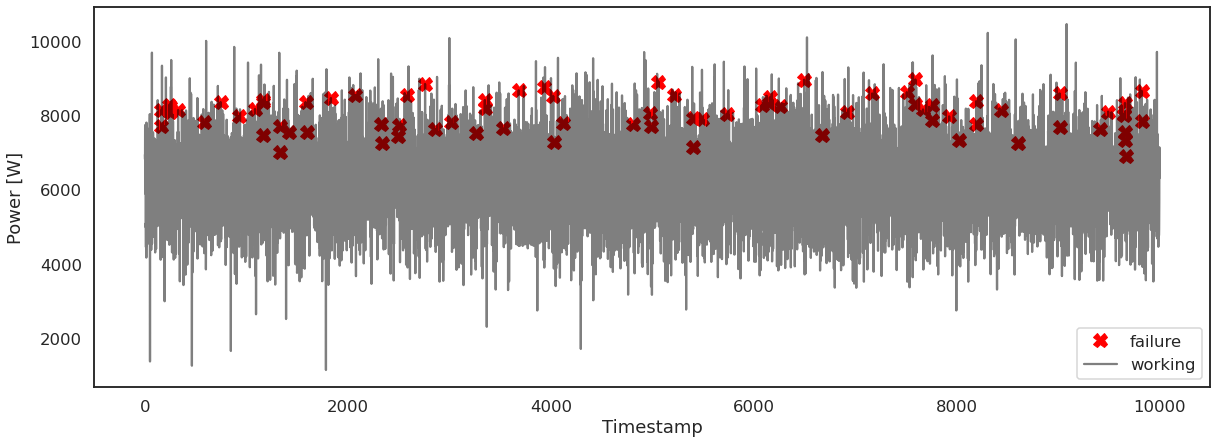

In [9]:
TF=pm[pm['Failure Type']==2]
sns.set_context('talk')
_ = plt.figure(figsize=(20,7))
_ = plt.plot(TF['Power [W x sec]'], linestyle='none', marker='X', color='red', markersize=14, label='failure')
_ = plt.plot(pm['Power [W x sec]'], color='black',linestyle='-', label='working',alpha=0.5)
_ = plt.ylabel('Power [W]')
_ = plt.xlabel('Timestamp')
_ =plt.legend(loc="lower right")
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/powerfailurePM.png') 

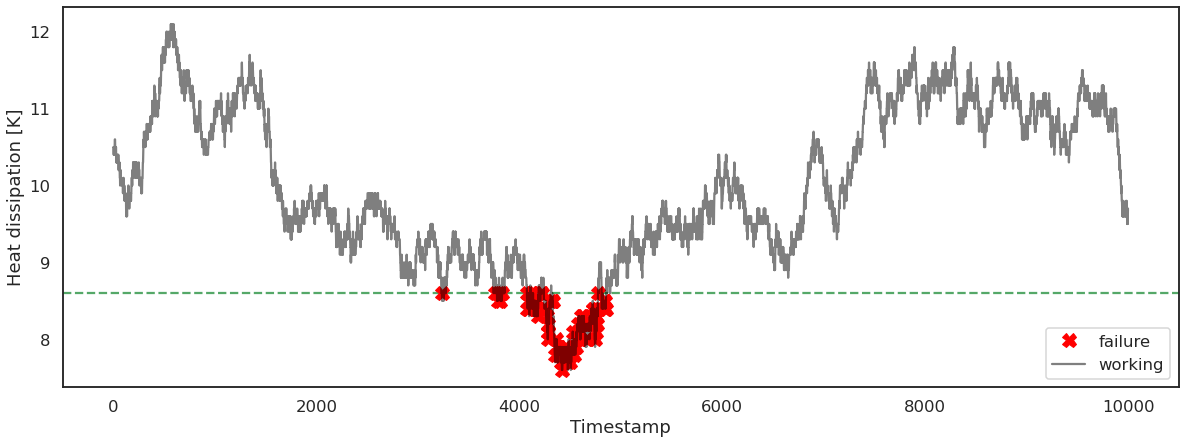

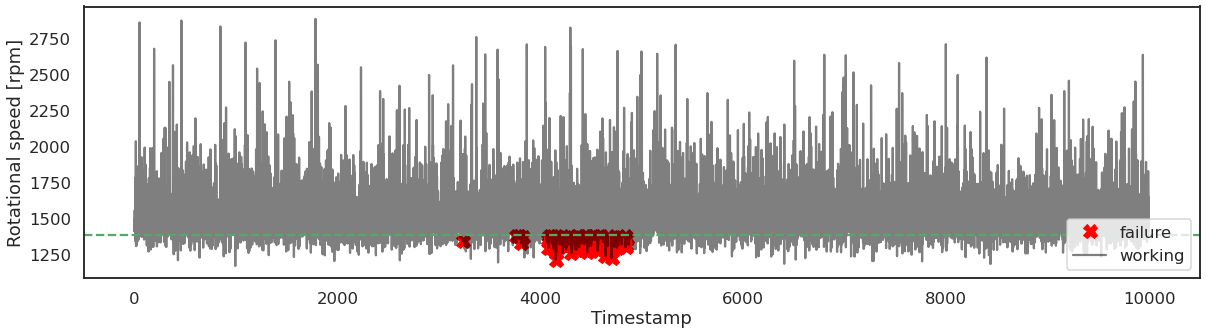

In [55]:
TF=pm[pm['Failure Type']==0]
sns.set_context('talk')
_ = plt.figure(figsize=(20,7))
_ = plt.axhline(y=8.6, color='g', linestyle='--')
_ = plt.plot(TF['Heat dissipation [K]'], linestyle='none', marker='X', color='red', markersize=14, label='failure')
_ = plt.plot(pm['Heat dissipation [K]'], color='black', label='working',alpha=0.5)
_ = plt.ylabel('Heat dissipation [K]')
_ = plt.xlabel('Timestamp')
_ =plt.legend(loc="lower right")
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/heatdissipationfailurePM1.png') 
sns.set_context('talk')
_ = plt.figure(figsize=(20,5))
_ = plt.plot(TF['Rotational speed [rpm]'], linestyle='none', marker='X', color='red', markersize=14, label='failure')
_ = plt.plot(pm['Rotational speed [rpm]'], color='black', label='working',alpha=0.5)
_ = plt.axhline(y=1380, color='g', linestyle='--')
_ = plt.ylabel('Rotational speed [rpm]')
_ = plt.xlabel('Timestamp')
_ =plt.legend(loc="lower right")
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/heatdissipationfailurePM2.png') 

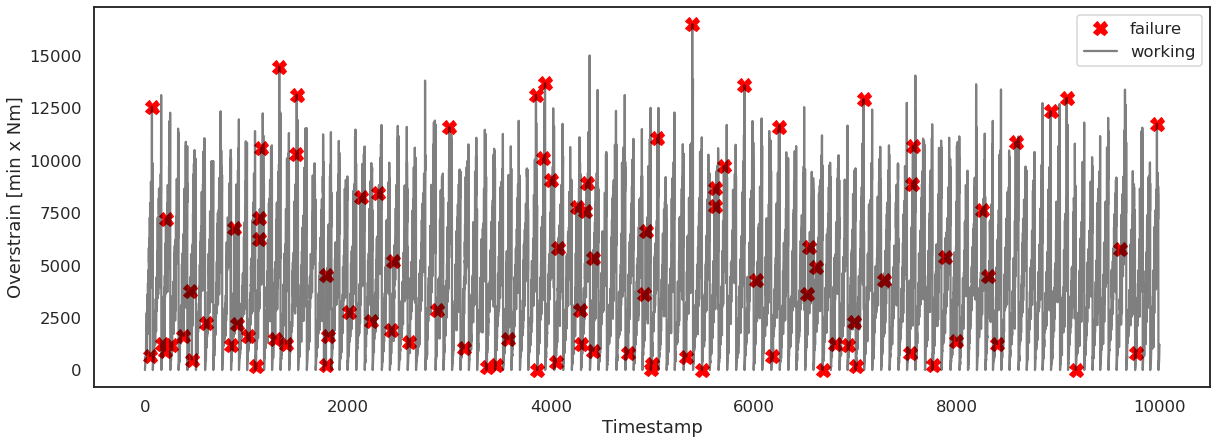

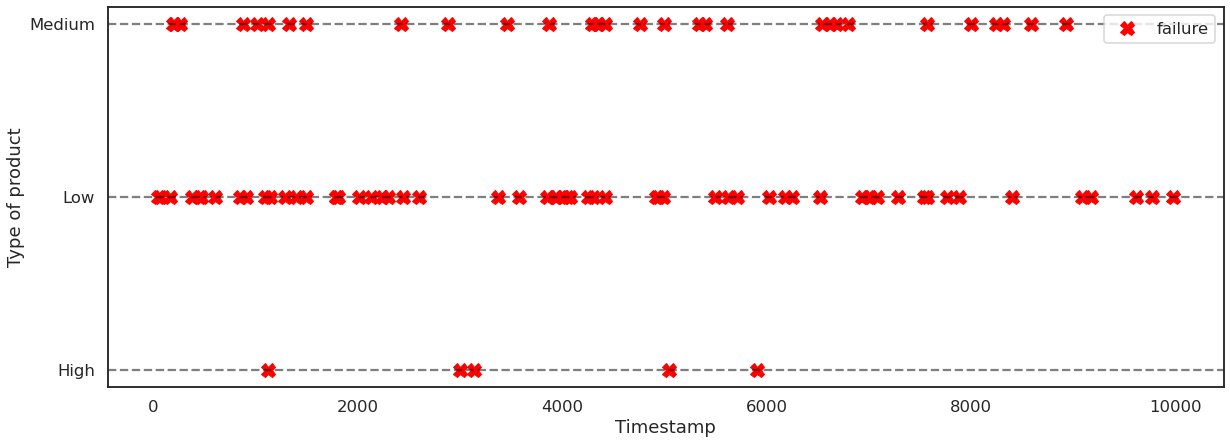

In [11]:
TF=pm[pm['Failure Type']==3]
sns.set_context('talk')
_ = plt.figure(figsize=(20,7))
_ = plt.plot(TF['Overstrain [min x Nm]'], linestyle='none', marker='X', color='red', markersize=14, label='failure')
_ = plt.plot(pm['Overstrain [min x Nm]'], color='black', label='working',alpha=0.5)
_ = plt.ylabel('Overstrain [min x Nm]')
_ = plt.xlabel('Timestamp')
_ =plt.legend(loc="upper right")
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/overstrainfailurePM1.png') 
sns.set_context('talk')
_ = plt.figure(figsize=(20,7))
_ = plt.plot(TF['Type'], linestyle='none', marker='X', color='red', markersize=14, label='failure')
_ = plt.ylabel('Type of product')
_ = plt.xlabel('Timestamp')
_ = plt.axhline(y=0, color='black', linestyle='--',alpha=0.5)
_ = plt.axhline(y=1, color='black', linestyle='--',alpha=0.5)
_ = plt.axhline(y=2, color='black', linestyle='--',alpha=0.5)
_ = plt.yticks([0,1,2], labels=['High','Low','Medium'])
_ =plt.legend(loc="upper right")
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/overstrainfailurePM2.png') 

Plausability of failure defined as the mean of 0/1 labels of the observations greater or equal than a certain value for a single variable. All variables are positive definite, the failure occurs when a certain value of a variables exceed the limit. 

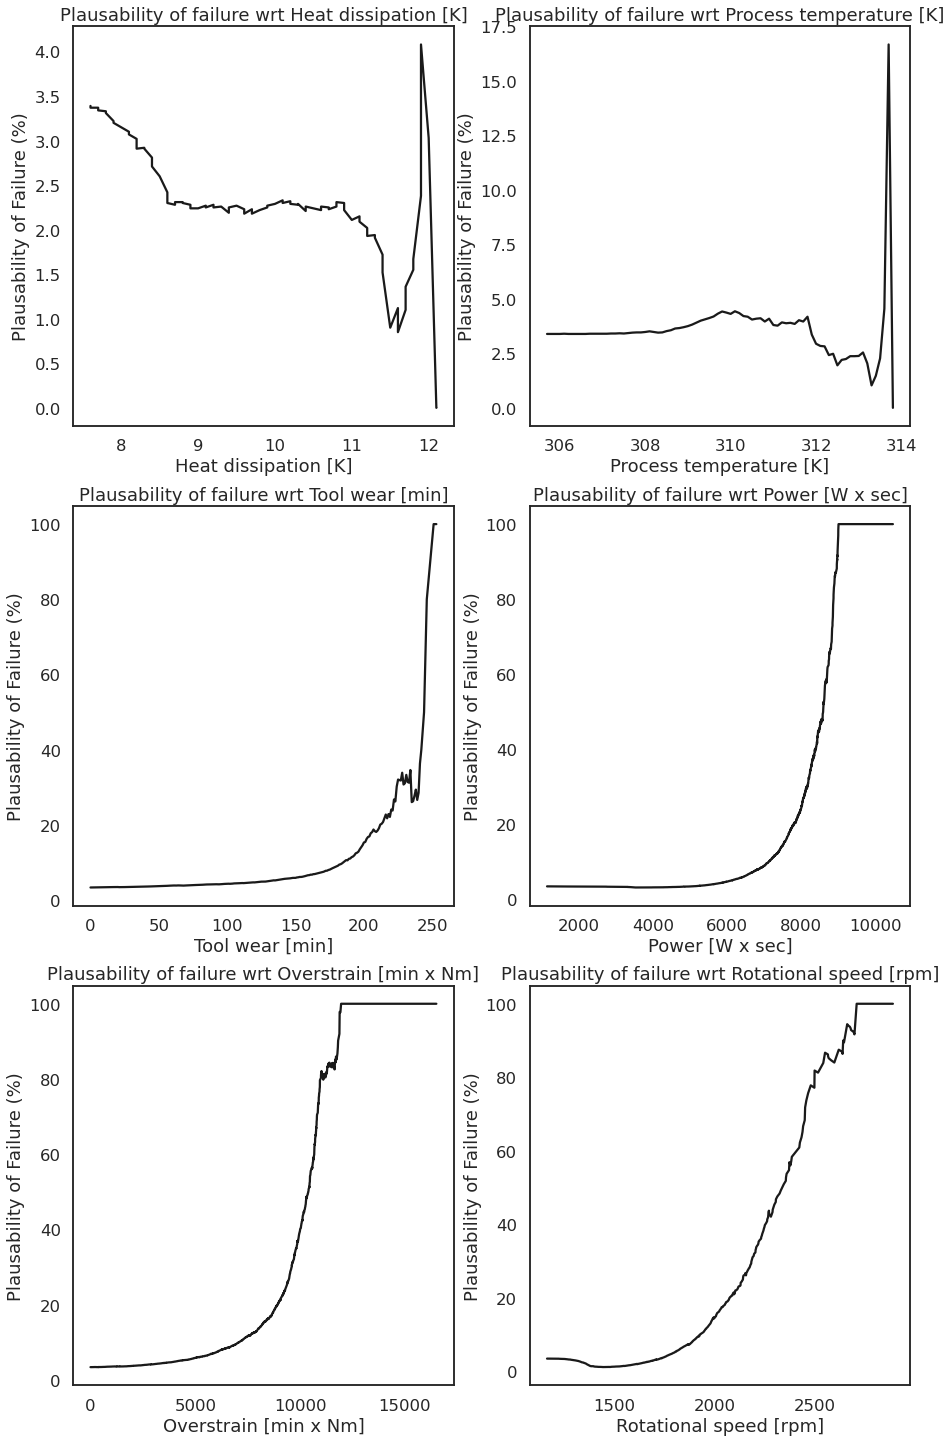

In [12]:
plt.figure(figsize=(15,25))
m=1
for i in ['Heat dissipation [K]','Process temperature [K]', 'Tool wear [min]', 'Power [W x sec]','Overstrain [min x Nm]','Rotational speed [rpm]'] :
    plt.subplot(3,2,m).set_title(label=("Plausability of failure wrt "+i))
    x,y = feat_prob(i,pm)
    plt.xlabel(i)
    plt.ylabel("Plausability of Failure (%)")
    sns.lineplot(y=y,x=x,color='k')
    m+=1
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/plausabilityoffailurePM.png') 


- Predict the Machine status and the type of failure based on the values of the regressors.  Multioutput approach using as target variables both the machine status and the type of failure. Multioutput classifier fits one classifier per target, in this case 2 classifiers as the number of target is 2. 
- Two ensamble boosting learning models and one bagging learning model are tried with decision trees: AdamBoost Classifier and GradientBoost Classifier which differ in the way they learn from previous mistake and RandomForest Classifier which train a bunch of individual models in a parallel way without depending from previous model. An informed search based on bayes optimization is used in the three cases in order to choose the best set of hyperparameters that maximize the target metric of the failure type.
- A Neural Network (MLP) is built to compare the performance of the other machine learning algorithms. As for the other models an informed search based on bayes optimization is proposed. 

AdamBoost Classifier begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

Gradient Boosting builds an additive model in a forward stage-wise fashion. Regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. it learns from the mistake  residual error directly, rather than update the weights of data points.

RandomForest Classifier fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

MultiLayerPerceptor Classifier implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation. It supports multioutputs by changing the output layer activator: the softmax activator is used with multiclass while the logistic activator is  used with binary output. 

Ensamble learning algorithms are not sensible to scaling. However the (MLP) is sensitive to featue scaling. In order to compare the performances with the same input data I applied a scaling on the features to obtain all values within the range 0,1. Test data are scaled using min and max values of each features of the train set to simulate unseen data. 33% of the dataset is used as test set.

The random forest uses bootstrap sampling and feature sampling such as row sampling and column sampling. Therefore Random Forest is not affected by multicollinearity that much since it is picking different set of features for different models and of course every model sees a different set of data point. Moreover in general decision trees are by nature immune to multi-collinearity. Base learners (decision tree) performs feature selection by selecting appropriate split points.For example, if you have 2 features which are 99% correlated, when deciding upon a split the tree will choose only one of them. Other models such as Logistic regression would use both the features. For these reasons I decided to use all variables without delete the most correlated ones.


In [13]:
split=split_training_testing(pm,0.33)

### Target to be maximized
Despite the multioutput setting the target to be maximized in the bayes optimization is computed only on the type of failure labels. The machine status is implicity connected with the type of failure (check in the correlation map the value between Target and Failure Type). 
In extending a binary metric to multiclass or multilabel problems, the data is treated as a collection of binary problems, one for each class. There are then a number of ways to average binary metric calculations across the set of classes, each of which may be useful in some scenario.  Where available, you should select among these using the average parameter. 
- Balanced Accuracy Score: it is defined as the "macro" average of recall computed per each class. Alternatively can be seen as the accuracy where each unit is weighted proportionally to the inverse prevalence of its true class. 

https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data


### Set of hyperparameters for Gradient boost classifier: 
- learning rate: contribution of each tree
- max_features: the number of features to consider when looking for the best split max=1 to avoid multicollinearity
- max_depth: limit for the number of nodes in the three 
- n_estimators: the number of boosting stages to perform (number of individual tree (base learners) estimators to be fitted)
- subsample: the fraction of samples to be used for fitting the individual base learners.


In [14]:
params_gb=grid_gbm(split[2],split[4],'micro')

|   iter    |  target   | learni... | max_depth | max_fe... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.3463   |  0.616    |  3.353    |  0.8872   |  133.8    |  0.8591   |
|  2        |  0.8952   |  0.1577   |  2.18     |  0.884    |  96.71    |  0.8675   |
|  3        |  0.08262  |  0.9908   |  3.902    |  0.8162   |  126.9    |  0.9242   |
|  4        |  1.0      |  0.2815   |  5.73     |  0.8237   |  85.18    |  0.9802   |
|  5        |  0.9929   |  0.796    |  8.725    |  0.963    |  149.4    |  0.9155   |
|  6        |  0.5238   |  0.8156   |  5.371    |  0.8055   |  111.8    |  0.8211   |
|  7        |  0.4654   |  0.819    |  7.582    |  0.9131   |  99.2     |  0.9997   |
|  8        |  1.0      |  0.1467   |  6.923    |  0.897    |  108.4    |  0.9456   |
|  9        |  0.9928   |  0.3296   |  5.204    |  0.8638   |  146.3    |  0.9837   |
|  10       |  0.2835   |  0.8157   |  2.273    |  0.9

In [15]:
classifier = GradientBoostingClassifier(random_state=123, **params_gb)
multi_target_classifier = MultiOutputClassifier(classifier, n_jobs=-1)
multi_target_classifier.fit(split[2], split[4])
y_pred_test=multi_target_classifier.predict(split[3])


Precision, Recall, F1  with micro-average: "micro" average gives each sample-class pair an equal contribution to the overall metric. Rather than summing the metric per class, this sums the dividends and divisors that make up the per-class metrics to calculate an overall quotient. Micro-averaging may be preferred in multilabel settings, including multiclass classification where a majority class is to be ignored. 
Precision, Recall, F1-score in micro averaging return the same scores due to the large number of True Positive from the No failure class. Despite the high values registered the aim of the micro-averaging in the analysis such as also balanced accuracy is to take in account the unbalance of the classes. 

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin



In [16]:
# performance micro
print(performance_failure_type(split[5],y_pred_test,'micro'))

Test Precision (Failure Type)      :  98.85 %
Test Recall (Failure Type)         :  98.85 %
Test F1-Score (Failure Type) :  98.85 %
Test Balanced Accuracy Score (Failure Type): 76.28 %
()


"macro" average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric.
Macro-average methods can be used when you want to know how the system performs overall across the entire set of data. You should not come up with any specific decision with this average, in fact the target to be maximized with the bayesian optimization is the balanced accuracy score. 
In general it's not correct to compare micro and macro averages results because they are computed in a different way.  

In [17]:
# Performance Metrics macro
print(performance_failure_type(split[5],y_pred_test,'macro'))

Test Precision (Failure Type)      :  77.2 %
Test Recall (Failure Type)         :  76.28 %
Test F1-Score (Failure Type) :  76.6 %
Test Balanced Accuracy Score (Failure Type): 76.28 %
()


In [18]:
# Performance Machine status
print(performance_machine_status(split[5],y_pred_test))

Test Precision (Machine Status)      :  86.24 %
Test Recall (Machine Status)         :  81.74 %
Test F1-score (Machine Status) :  83.93 %
()


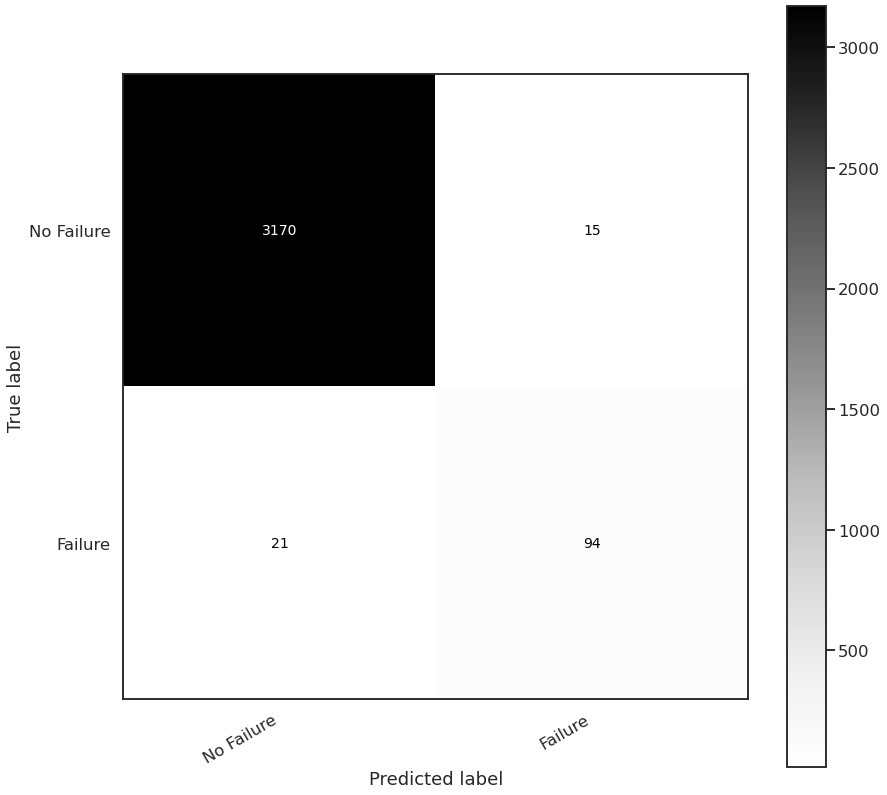

In [19]:
confusion_machine_status(split[5],y_pred_test,)
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/gradientboostmachinestatusPM.png') 

The binary classification of the machine status works, the number of false positive is not significant greater than the number of false negative meaning that the unbalance of the dataset is mitigate.

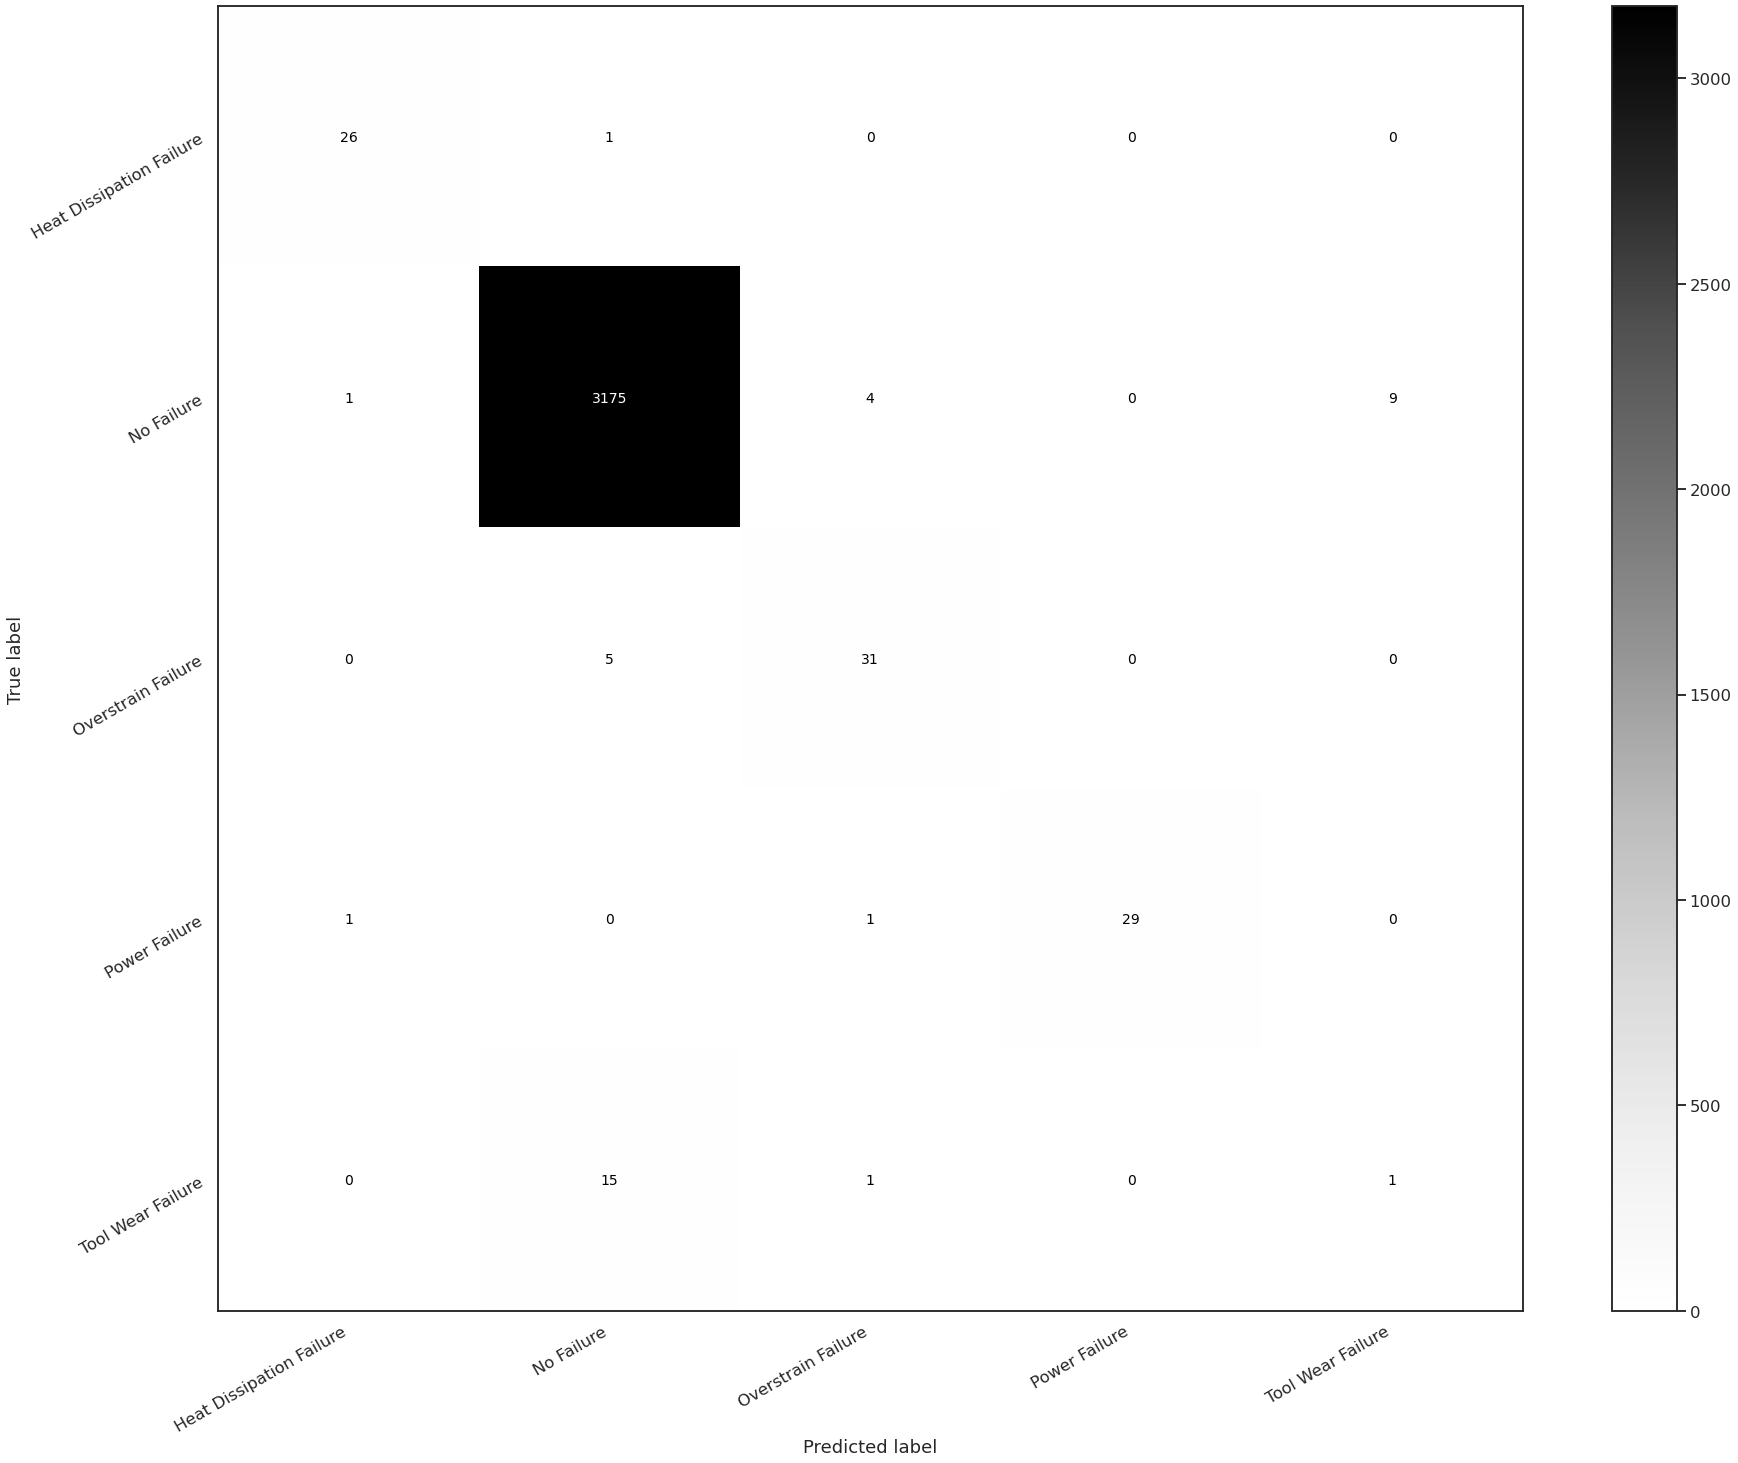

In [20]:
confusion_failure_type(split[5],y_pred_test,)
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/gradientboostfailuretypePM.png') 

Overstrain, Power and Heat dissipation failures are the one better identified, while Tool Wear Failures are  mainly undetected. Notice that Tool wear Failure is the class with less observations. 

### Set of hyperparameters for Adaboost classifier, decision tree as base learner: 
- learning rate: weight applied to each classifier at each boosting iteration.
- n_estimators: the maximum number of base learner at which boosting is terminated.

In [21]:
params_ab=grid_abm(split[2],split[4],'micro')

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
|  1        |  0.8011   |  0.616    |  91.83    |
|  2        |  0.6559   |  0.4417   |  133.8    |
|  3        |  0.5953   |  0.3024   |  90.44    |
|  4        |  0.7197   |  0.03225  |  109.4    |
|  5        |  0.5573   |  0.2463   |  103.6    |
|  6        |  0.4      |  0.9908   |  96.64    |
|  7        |  0.5642   |  0.09038  |  126.9    |
|  8        |  0.6777   |  0.625    |  99.2     |
|  9        |  0.5907   |  0.4716   |  88.29    |
|  10       |  0.5521   |  0.08322  |  143.1    |
|  11       |  0.8593   |  0.796    |  138.8    |
|  12       |  0.7359   |  0.8171   |  149.4    |
|  13       |  0.845    |  0.5815   |  137.0    |
|  14       |  0.7389   |  0.4271   |  81.92    |
|  15       |  0.5645   |  0.4596   |  87.37    |
|  16       |  0.743    |  0.819    |  128.8    |
|  17       |  0.7744   |  0.5696   |  99.2     |
|  18       |  0.4      |  0.9985   |  89.66    |


In [22]:
classifier = AdaBoostClassifier(random_state=123, **params_ab)
multi_target_classifier = MultiOutputClassifier(classifier, n_jobs=-1)
multi_target_classifier.fit(split[2],split[4])
y_pred_test=multi_target_classifier.predict(split[3])

In [23]:
# Performance Metrics micro
print(performance_failure_type(split[5],y_pred_test,'micro'))

Test Precision (Failure Type)      :  86.24 %
Test Recall (Failure Type)         :  86.24 %
Test F1-Score (Failure Type) :  86.24 %
Test Balanced Accuracy Score (Failure Type): 76.17 %
()


In [24]:
# Performance Metrics macro
print(performance_failure_type(split[5],y_pred_test,'macro'))

Test Precision (Failure Type)      :  75.59 %
Test Recall (Failure Type)         :  76.17 %
Test F1-Score (Failure Type) :  71.06 %
Test Balanced Accuracy Score (Failure Type): 76.17 %
()


In [25]:
# Performance Metrics Machine Status
print(performance_machine_status(split[5],y_pred_test))

Test Precision (Machine Status)      :  81.32 %
Test Recall (Machine Status)         :  64.35 %
Test F1-score (Machine Status) :  71.84 %
()


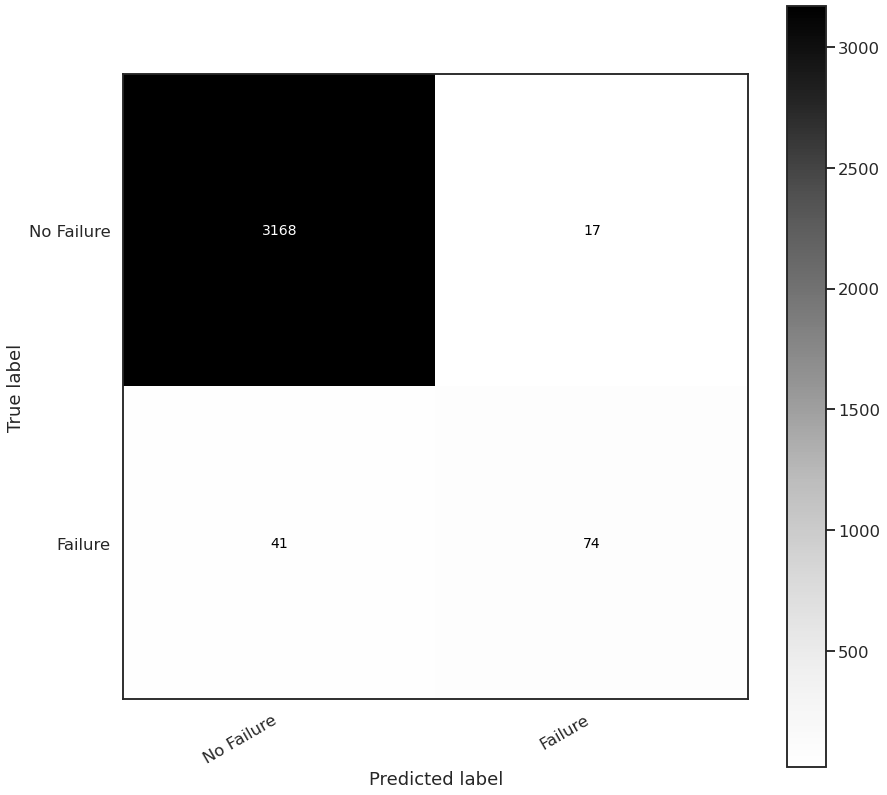

In [26]:
confusion_machine_status(split[5],y_pred_test,)
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/adaboostmachinestatusPM.png') 

The classification of the  machine status is worst than in the case of Gradient boost classifier but still acceptable. 

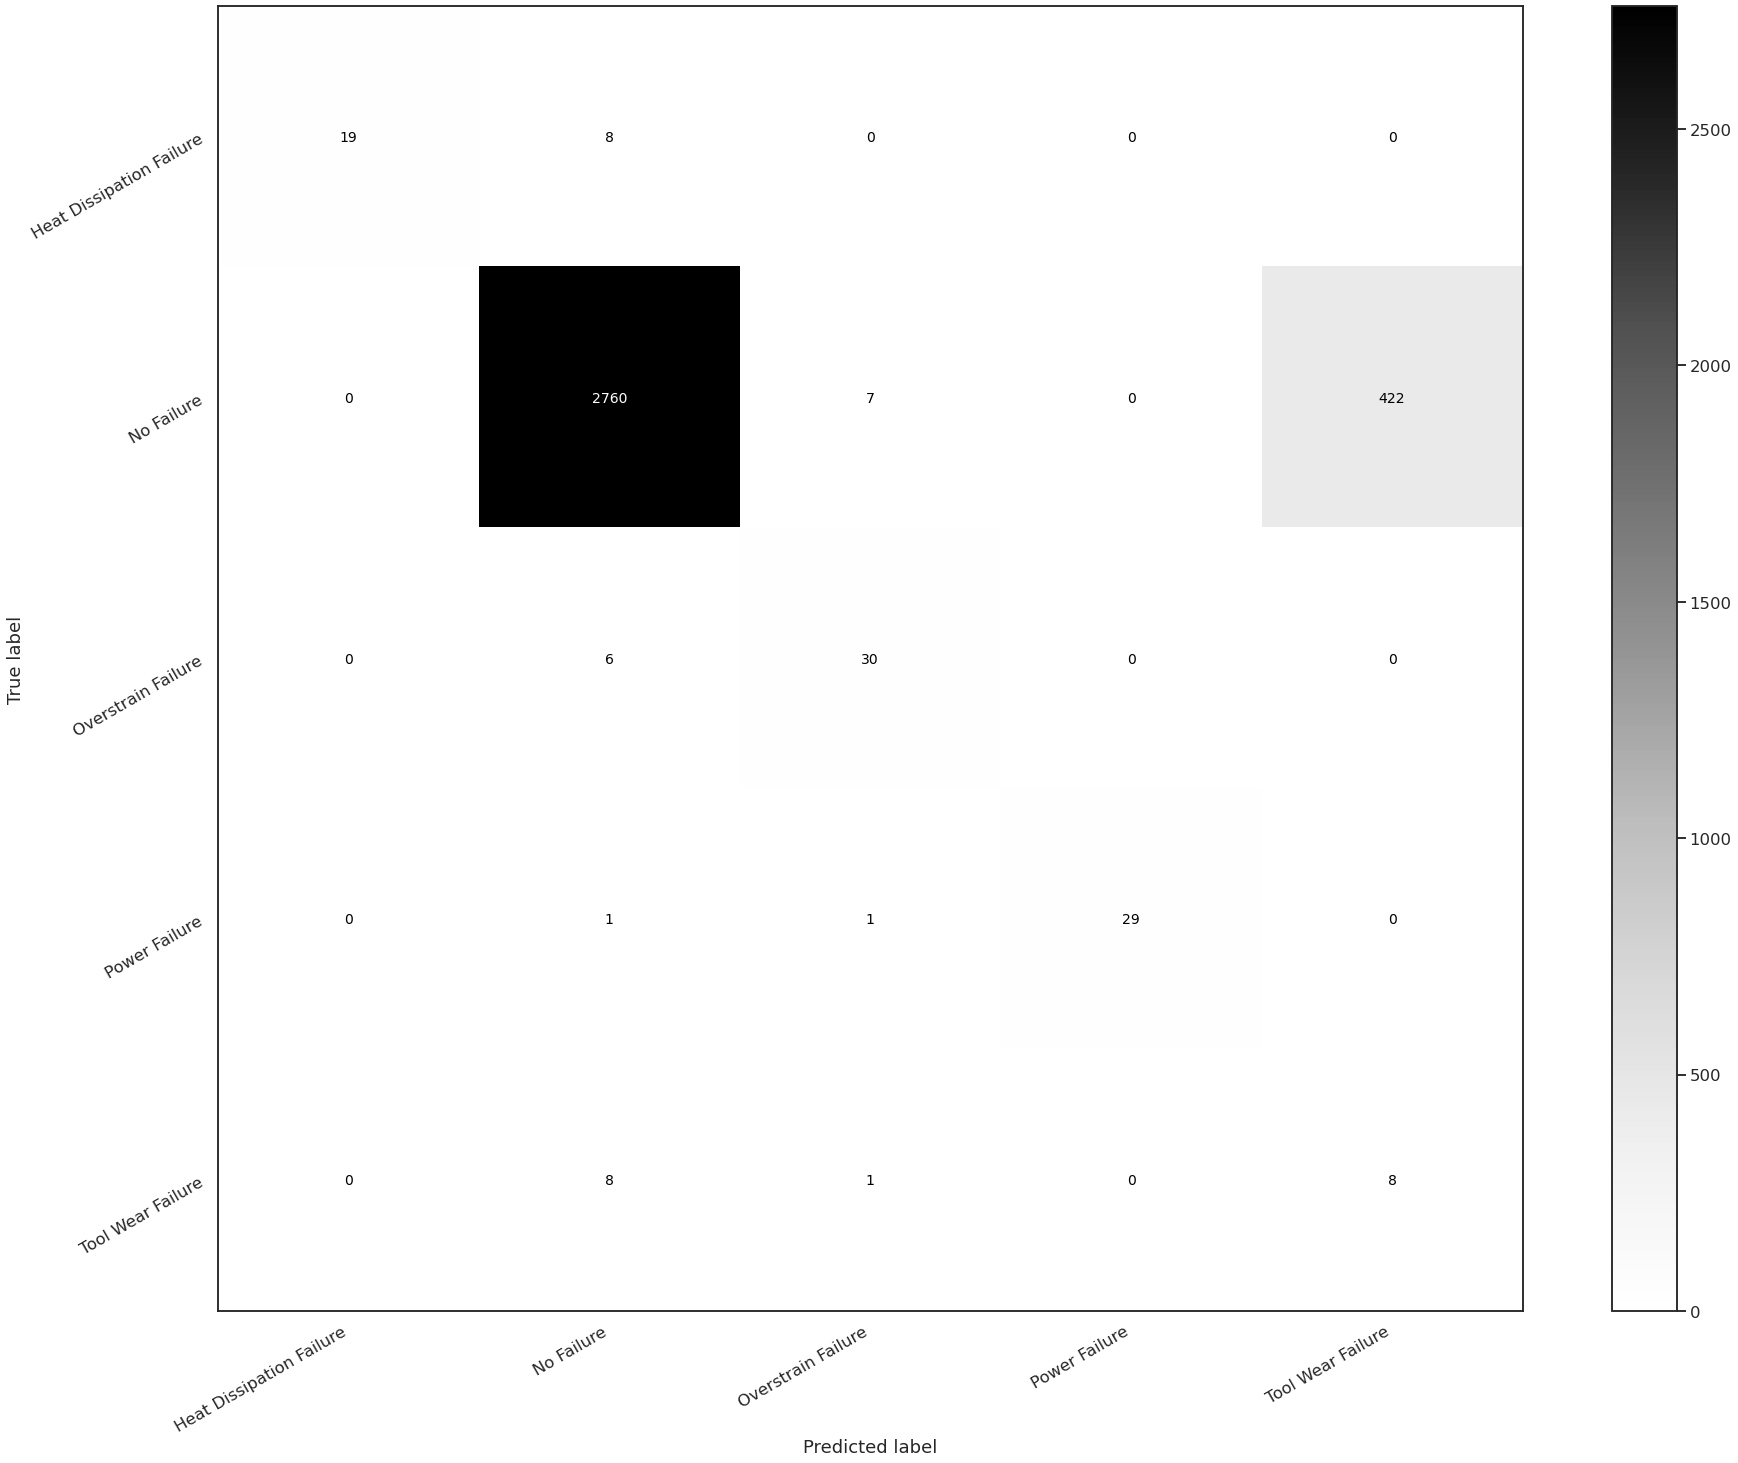

In [27]:
confusion_failure_type(split[5],y_pred_test,)
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/adaboostfailuretypePM.png') 

The classification of the type of failures shows better results than gradient boost classifier for Tool Wear Failure, while Heat dissipation Failure and No failure classes are slightly worst. As in case of gradient boost classifier Overstrain Failure and Power Failure work good. The improvment in the classification of Tool wear failure and the worsening in the classification of No failure with respect to Gradient boost estimator depend on how unit weights are individually modified. As the iterations move forwards  Units that are difficult to classify receive more influence. The following decision tree will focus on units missed by the previous ones, however this could lead to misclassification of units similar to the ones which receives more importance.    

### Random Forest Classifier hyperparameters: 
- max_depth: maximum number of nodes in the tree, the maximum depth of the tree.
- max_features: the number of features to consider when looking for the best split:
- n_estimators: number of trees in the forest

In [28]:
params_rf=grid_rfm(split[2],split[4],'micro')

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.8142   |  7.285    |  0.8338   |  110.5    |
|  2        |  0.8285   |  8.385    |  0.8591   |  90.44    |
|  3        |  0.6093   |  3.157    |  0.884    |  96.71    |
|  4        |  0.8068   |  5.364    |  0.9981   |  96.64    |
|  5        |  0.6094   |  3.568    |  0.9339   |  123.5    |
|  6        |  0.6046   |  4.92     |  0.8932   |  88.29    |
|  7        |  0.6141   |  3.518    |  0.9802   |  135.6    |
|  8        |  0.8286   |  8.884    |  0.963    |  149.4    |
|  9        |  0.8284   |  7.041    |  0.9628   |  109.5    |
|  10       |  0.6138   |  3.192    |  0.8908   |  87.37    |
|  11       |  0.8285   |  8.721    |  0.9395   |  119.6    |
|  12       |  0.6069   |  4.92     |  0.9997   |  89.66    |
|  13       |  0.8284   |  7.308    |  0.897    |  108.4    |
|  14       |  0.8285   |  8.095    |  0.8646   |  108.0    |
|  15   

In [29]:
classifier = RandomForestClassifier(random_state=123,**params_rf)
multi_target_classifier = MultiOutputClassifier(classifier, n_jobs=-1)
multi_target_classifier.fit(split[2], split[4])
y_pred_test=multi_target_classifier.predict(split[3])

In [30]:
# Performance Metrics micro
print(performance_failure_type(split[5],y_pred_test,'micro'))

Test Precision (Failure Type)      :  99.18 %
Test Recall (Failure Type)         :  99.18 %
Test F1-Score (Failure Type) :  99.18 %
Test Balanced Accuracy Score (Failure Type): 77.9 %
()


In [31]:
# Performance Metrics macro
print(performance_failure_type(split[5],y_pred_test,'macro'))

Test Precision (Failure Type)      :  86.54 %
Test Recall (Failure Type)         :  77.9 %
Test F1-Score (Failure Type) :  78.7 %
Test Balanced Accuracy Score (Failure Type): 77.9 %
()


In [32]:
# Performance Metrics Machine Status
print(performance_machine_status(split[5],y_pred_test))

Test Precision (Machine Status)      :  92.93 %
Test Recall (Machine Status)         :  80.0 %
Test F1-score (Machine Status) :  85.98 %
()


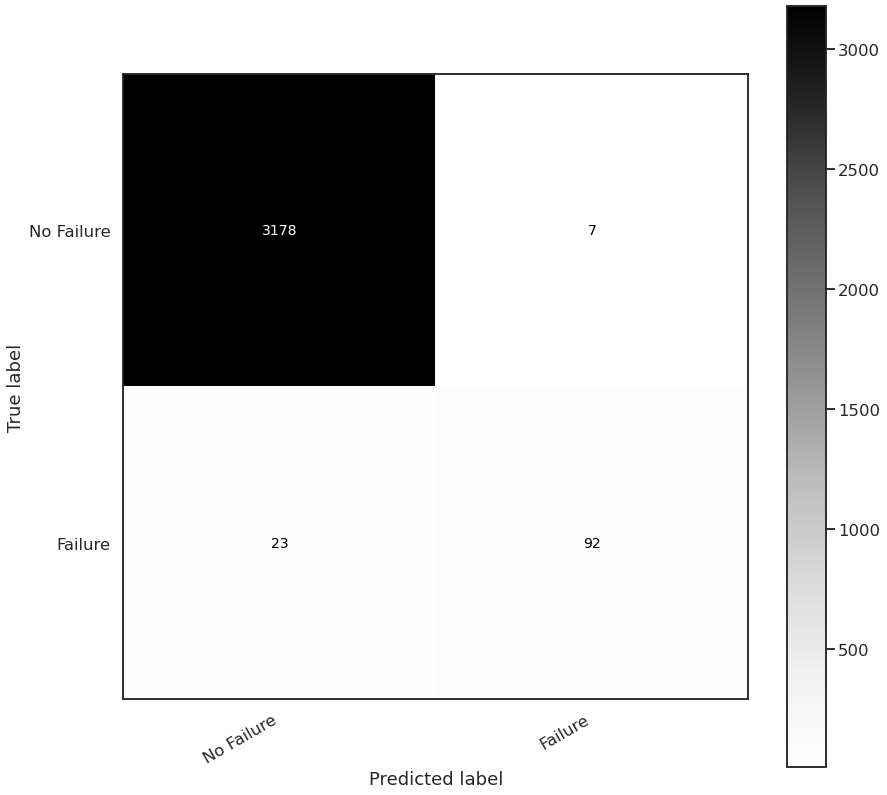

In [33]:
# Confusion Matrix
confusion_machine_status(split[5],y_pred_test,)
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/randomforestmachinestatusPM.png') 

The classification of the machine status shows convincing result. As in the case of gradient boost classifier the number of false positive is not too high, and the number of false negative close to zero. Random forest performance is robust to unbalance of the dataset. 

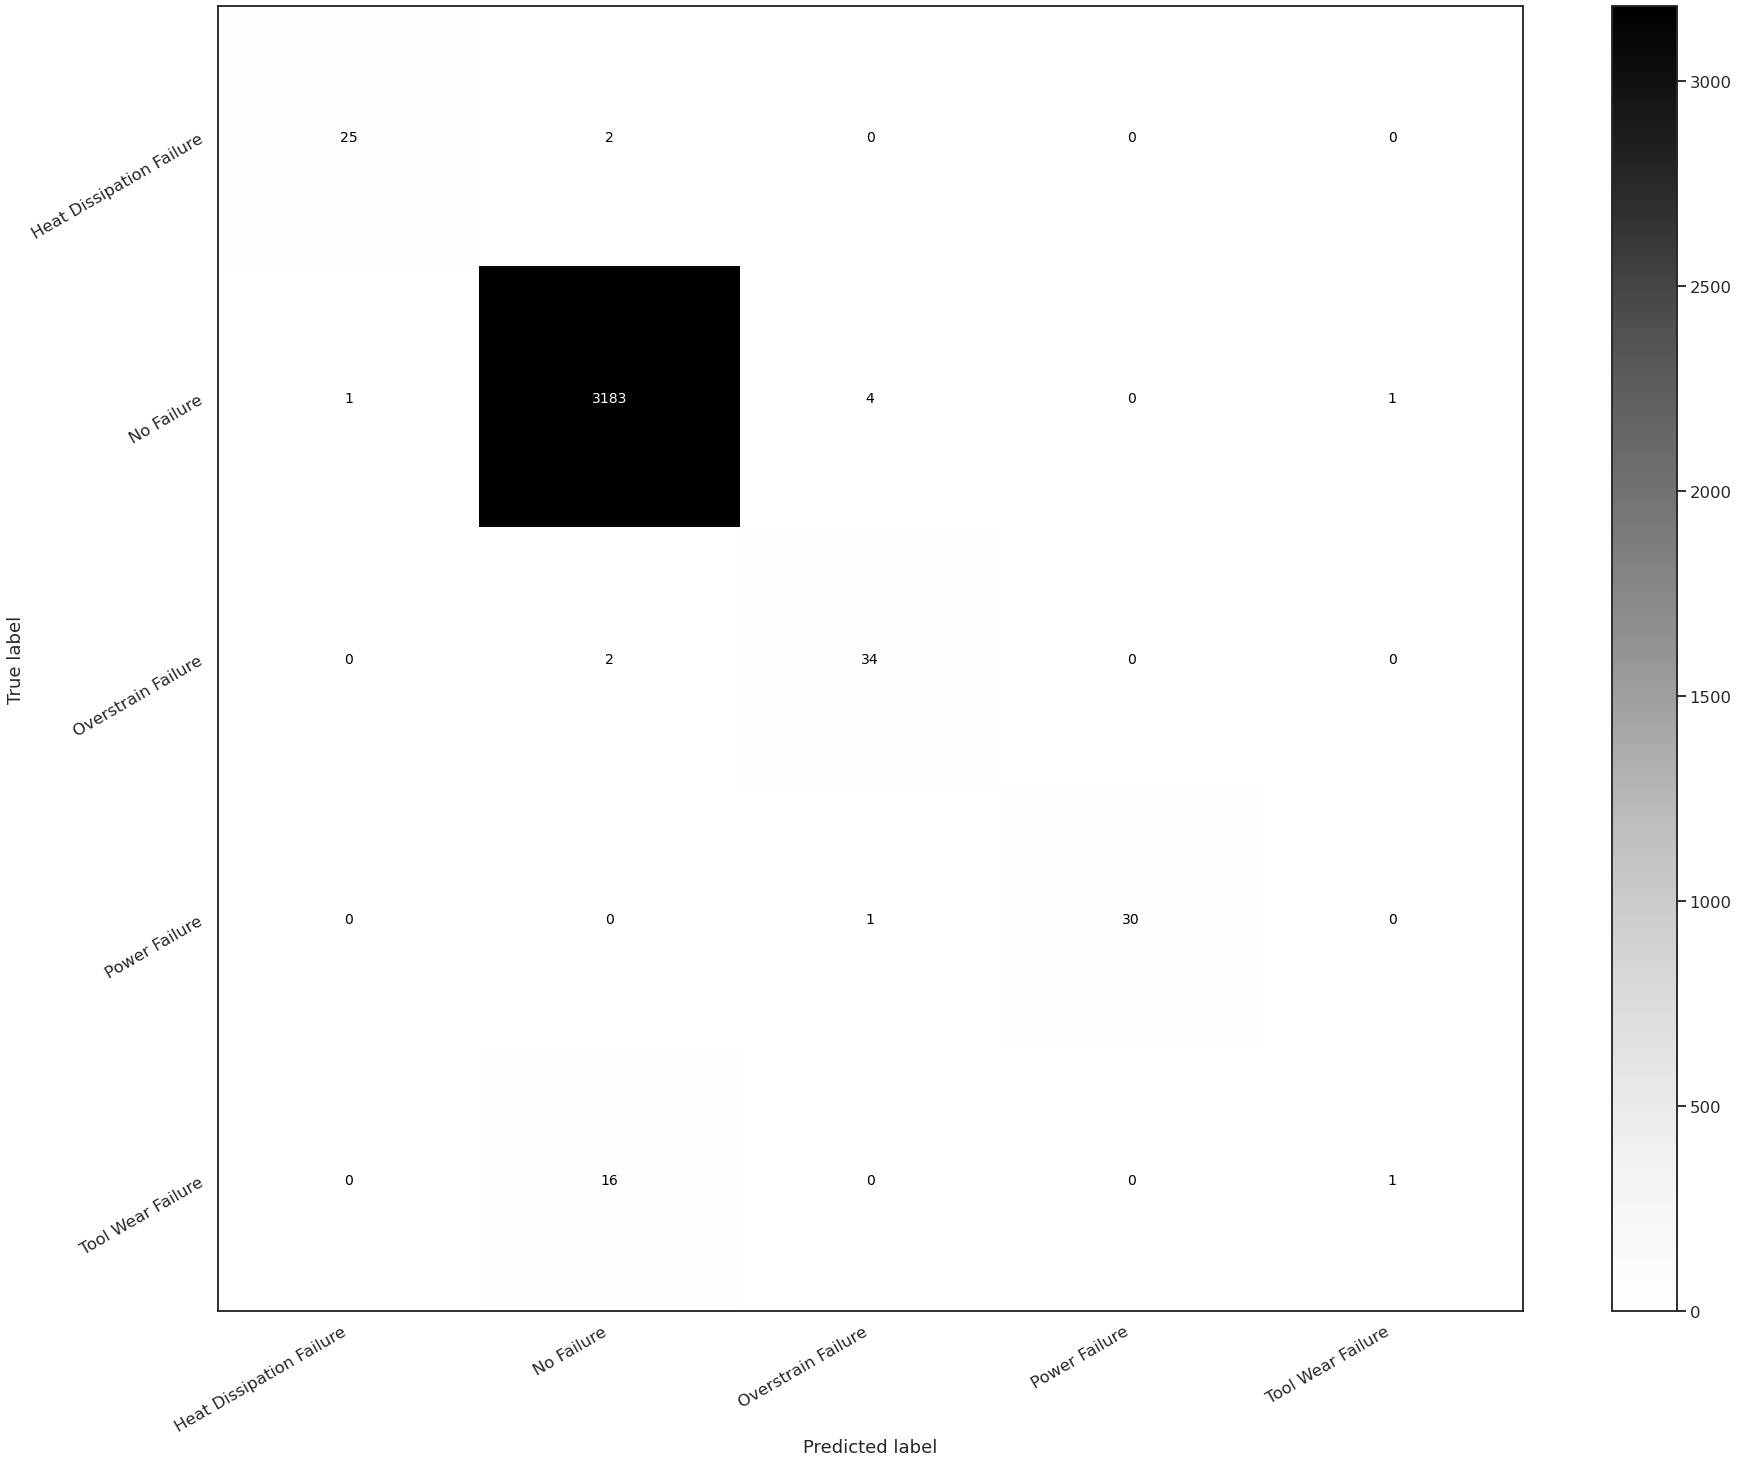

In [34]:
confusion_failure_type(split[5],y_pred_test,)
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/randomforestfailuretypePM.png')

As also in the case of gradient boost classifier the majority of false positive is due to the tool wear failures. Heat dissipation, Power and Overstrain failures are the ones better identified. 

## MLP classifier hyperparameters:
- hidden_layer_sizes: tuple that indicates the number of layers and the correspondent number of neurons
- activation: activation functions for the hidden layers.
- solver: algorithm to be used in the weights optimizations Quasi Newton vs stochastic gradient descent solvers .
- alpha: L2 regularization term, bias-variance trade off to prevent overfitting. 
- learning_rate: learning rate for weights update:  constant, adaptive (decrease if two consecutive epochs fail to improve the loss), gradually decrease proportionally to time step. 
- mini_batch: ize of minibatches for stochastic gradient optimizers. If the solver is Quasi-newton the classifier will not use minibatch.
- max_iter: maximum number of iterations before the algorithm is stopped in the  estimation of the weights. For stochastic solvers this determines the number of epochs (how many times each data point will be used). 
- early_stopping: boolean to decide if using early stopping to terminate training when validation score is not improving. 
- validation_fraction: The proportion of training data kept aside as validation set for early stopping. Used only if earrly stopping equal to True. 
- Momentum: only used when solver=’sgd’ (stocastic gradient descent), momentum for weights update.

In [48]:
params_mlp=grid_nn_ef(split[2],split[4],'micro')

|   iter    |  target   | activa... |   alpha   | batch_... | early_... | initia... | max_iter  | momentum  | neurons1  | optimizer | valida... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8118   |  2.443    |  0.001699 |  64.84    |  1.531    |  0.883    |  8.015e+0 |  0.02248  |  12.94    |  0.7137   |  0.3343   |
|  2        |  0.6884   |  3.953    |  0.002385 |  25.09    |  1.333    |  1.858    |  8.027e+0 |  0.4662   |  10.83    |  0.2211   |  0.8918   |
|  3        |  0.289    |  3.168    |  0.008407 |  107.3    |  1.972    |  1.726    |  8.081e+0 |  0.4213   |  10.19    |  1.358    |  0.1043   |
|  4        |  0.2      |  3.261    |  0.00698  |  79.31    |  0.5457   |  2.985    |  8.014e+0 |  0.6154   |  13.4     |  1.211    |  0.7206   |
|  5        |  0.3381   |  1.288    |  0.004011 |  51.72    |  1.885    |  2.747    |  8.081e+0 |  0.03408  |  16.6     |  2

From the bayes optimization the layer sizes are: (7,16,5) for the failure type classification and (7,16,1) for the machine status classification. The tanh activation function is used for the hidden layer, while the weights are computed using lbfgs (Quasi Newton Approximation).

In [49]:
classifier = MLPClassifier(random_state=123,**params_mlp)
multi_target_classifier = MultiOutputClassifier(classifier, n_jobs=-1)
multi_target_classifier.fit(split[2], split[4])
y_pred_test=multi_target_classifier.predict(split[3])

In [50]:
# Performance Metrics micro
print(performance_failure_type(split[5],y_pred_test,'micro'))

Test Precision (Failure Type)      :  98.7 %
Test Recall (Failure Type)         :  98.7 %
Test F1-Score (Failure Type) :  98.7 %
Test Balanced Accuracy Score (Failure Type): 73.99 %
()


In [51]:
# Performance Metrics macro
print(performance_failure_type(split[5],y_pred_test,'macro'))

Test Precision (Failure Type)      :  73.97 %
Test Recall (Failure Type)         :  73.99 %
Test F1-Score (Failure Type) :  73.84 %
Test Balanced Accuracy Score (Failure Type): 73.99 %
()


In [52]:
# Performance Metrics Machine Status
print(performance_machine_status(split[5],y_pred_test))


Test Precision (Machine Status)      :  77.67 %
Test Recall (Machine Status)         :  69.57 %
Test F1-score (Machine Status) :  73.39 %
()


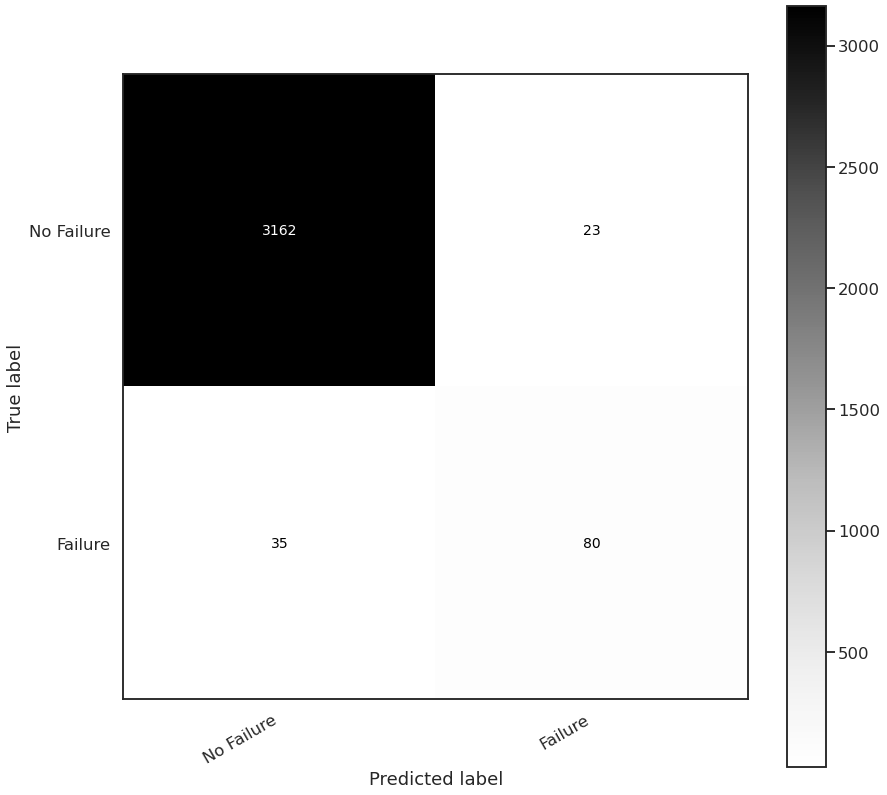

In [53]:
# Confusion Matrix
confusion_machine_status(split[5],y_pred_test,)
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/nnmachinestatusPM.png')

The performance for machine status classification is slightly worst than the ones obtained with machine learning models. Probably the architecture of the neural network is highly dependent on the output from which learn, that is the type of failure. In general this result shows a less generalization of the model architecture to map less complex problem.   

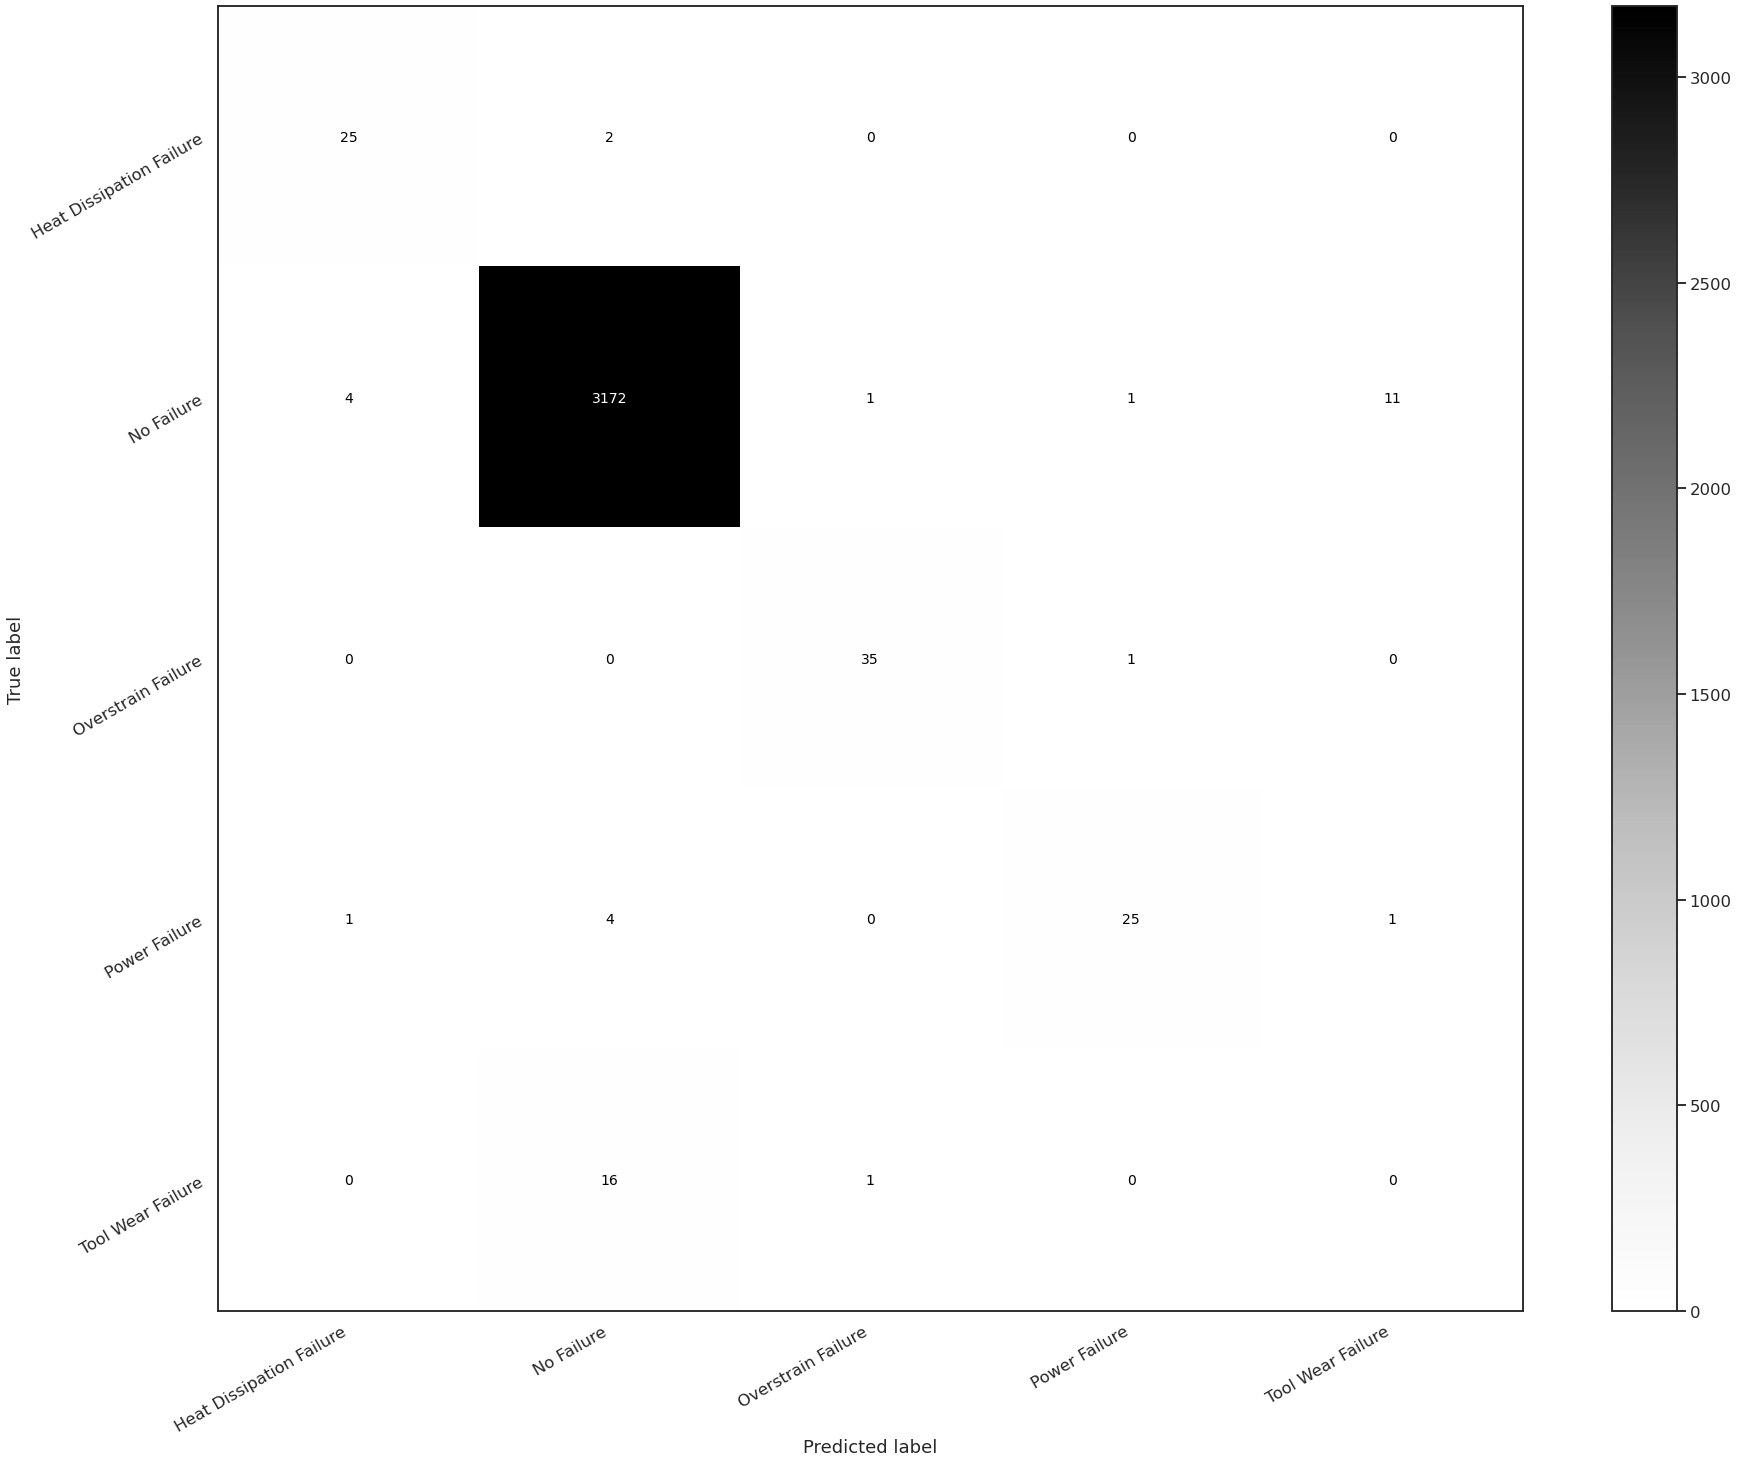

In [54]:
confusion_failure_type(split[5],y_pred_test,)
plt.savefig('/mnt/c/Users/NicolaRonzoni/OneDrive - BitBang Srl/imagesPM/nnfailuretypePM.png')

The multiclass classification results seem promising. The only misclassified class is Tool Wear Failure. The other 4 classes have good performance. 

### Outlooks
- The hyperparameter optimization from the type of failure perspective leads to good result in the classification of the machine status (less complex classification task) for all models. However MLP classifier in the machine status task from a type of failure perspective is the less accurate. The neural network architecture changes the number of neurons in the output layer switching from the failure type classication to the machine status classification.  
- Probably to increase the performance of the machine status classification with  MLP an hyperparameter optimization for this binary class is needed. 
- Tool wear failure is undetected in the four models. Two type of causes contribute: the number of observed failure in the dataset is quite small, how this failures are defined (random failures within a large range of Tool wear values).    
-  Balanced accuracy metrics used in the bayes optimization respond to the trade-off problem between micro and macro averiging. In general balanced accuracy score convergence to accuracy score in presence of balanced classes while avoid biased performance estimated when dealing with unbalanced dataset.  
- Precision, recall, F1-score with the micro-averaging returns the same scores in the evaluation of the test set, due to the large number of True positives detected (No failures).  